<a href="https://colab.research.google.com/github/CODEMAN251/mnist-cnn-onnx/blob/main/Code0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch torchvision opencv-python matplotlib numpy pandas onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [8]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saimanjunath251","key":"a05558cac652d11da058d8f9d61b0d4a"}'}

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip gtsrb-german-traffic-sign.zip -d gtsrb_data

Streaming output truncated to the last 5000 lines.
  inflating: gtsrb_data/train/5/00005_00053_00010.png  
  inflating: gtsrb_data/train/5/00005_00053_00011.png  
  inflating: gtsrb_data/train/5/00005_00053_00012.png  
  inflating: gtsrb_data/train/5/00005_00053_00013.png  
  inflating: gtsrb_data/train/5/00005_00053_00014.png  
  inflating: gtsrb_data/train/5/00005_00053_00015.png  
  inflating: gtsrb_data/train/5/00005_00053_00016.png  
  inflating: gtsrb_data/train/5/00005_00053_00017.png  
  inflating: gtsrb_data/train/5/00005_00053_00018.png  
  inflating: gtsrb_data/train/5/00005_00053_00019.png  
  inflating: gtsrb_data/train/5/00005_00053_00020.png  
  inflating: gtsrb_data/train/5/00005_00053_00021.png  
  inflating: gtsrb_data/train/5/00005_00053_00022.png  
  inflating: gtsrb_data/train/5/00005_00053_00023.png  
  inflating: gtsrb_data/train/5/00005_00053_00024.png  
  inflating: gtsrb_data/train/5/00005_00053_00025.png  
  inflating: gtsrb_data/train/5/00005_00053_00026.png

In [12]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

class GTSRBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))

        for label, class_folder in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_folder)
            for img_name in os.listdir(class_path):
                if img_name.endswith(".ppm") or img_name.endswith(".png") or img_name.endswith(".jpg"):
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [13]:
# Define image transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # For grayscale; update if color
])

# Create datasets
dataset = GTSRBDataset(root_dir="gtsrb_data/Train", transform=transform)

# Split into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"✅ Datasets ready — {len(train_dataset)} train, {len(val_dataset)} val")

✅ Datasets ready — 31367 train, 7842 val


In [14]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts [0, 255] → [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load datasets
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"✅ MNIST Loaded: {len(train_dataset)} train, {len(test_dataset)} test")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.02MB/s]

✅ MNIST Loaded: 60000 train, 10000 test


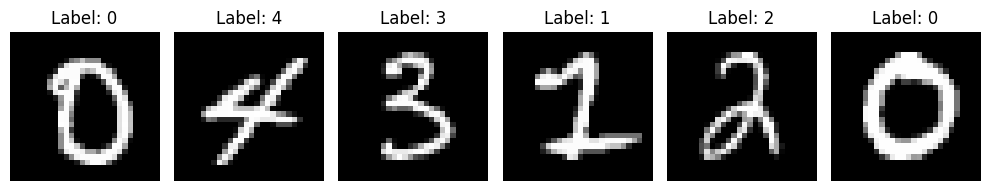

In [15]:
# Visualize a few samples
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"Label: {example_targets[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # output: 32x28x28
        self.pool = nn.MaxPool2d(2, 2)  # output after pool: 32x14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # output: 64x14x14
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))   # -> [32, 14, 14]
        x = self.pool(torch.relu(self.conv2(x)))   # -> [64, 7, 7]
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"📈 Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

📈 Epoch 1/5, Loss: 0.1515
📈 Epoch 2/5, Loss: 0.0439
📈 Epoch 3/5, Loss: 0.0306
📈 Epoch 4/5, Loss: 0.0226
📈 Epoch 5/5, Loss: 0.0180


In [19]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"🎯 Test Accuracy: {100 * correct / total:.2f}%")

🎯 Test Accuracy: 99.18%


In [20]:
torch.save(model.state_dict(), "mnist_cnn.pth")
print("✅ PyTorch model saved.")

✅ PyTorch model saved.


In [21]:
dummy_input = torch.randn(1, 1, 28, 28, device=device)  # (batch_size, channels, height, width)

torch.onnx.export(
    model,
    dummy_input,
    "mnist_cnn.onnx",
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=11
)

print("📦 Model exported to ONNX: mnist_cnn.onnx")

📦 Model exported to ONNX: mnist_cnn.onnx


In [22]:
import onnx

model_onnx = onnx.load("mnist_cnn.onnx")
onnx.checker.check_model(model_onnx)
print("✅ ONNX model is valid!")

✅ ONNX model is valid!


In [23]:
!pip install onnxruntime

In [25]:
import onnxruntime as ort
import numpy as np

# Load ONNX model
ort_session = ort.InferenceSession("mnist_cnn.onnx")

# Get one sample image from test set
image, label = test_dataset[0]
image = image.unsqueeze(0).numpy()  # shape: [1, 1, 28, 28]

# Run inference
outputs = ort_session.run(None, {"input": image})
predicted_class = np.argmax(outputs[0])

print(f"🖼️ True Label: {label}, 🎯 Predicted: {predicted_class}")

🖼️ True Label: 7, 🎯 Predicted: 7


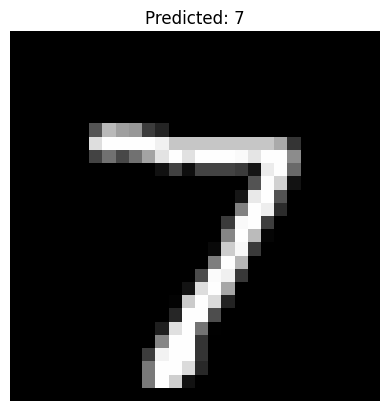

In [26]:
import matplotlib.pyplot as plt

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


In [28]:
!git config --global user.email "saimanjunathwalke25@gmail.com"
!git config --global user.name "CODEMAN251"
!git clone https://github.com/CODEMAN251/mnist-cnn-onnx.git
%cd mnist-cnn-onnx


Cloning into 'mnist-cnn-onnx'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), done.
/content/mnist-cnn-onnx


In [38]:
!find /content -type f -name "*.ipynb"
!find /content -type f -name "*.onnx"
!find /content -type f -name "*.pth"
!find /content -type f -name "*.pdf"


/content/mnist_cnn.onnx
/content/mnist_cnn.pth
/content/AI_Project_Summary_Final.pdf


In [47]:
#!mv /content/Code0.ipynb /content/mnist-cnn-onnx/
!find -type f -name "Code0.ipynb"

